TODO:
1. Train a model for each station instead of all in one
2. Reduce feature used

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [22]:
df_raw = pd.read_parquet("AvailabilityDataCombined.gzip")

In [23]:
df = df_raw.loc[df_raw["last_update"] > pd.to_datetime("2024-02-15 09:40:00")]

In [24]:
featuresList = ["number","last_update","available_bikes","banking","temp","feels_like","pressure","humidity","uvi","clouds","visibility","wind_speed","wind_deg","wind_gust","weather_main","rain","snow","weather_description"]
df = df[featuresList]

In [25]:
def addHourDayMonth(dfX):
    # Convert 'last_update' to datetime and extract useful features
    dfX['last_update'] = pd.to_datetime(dfX['last_update'])
    dfX['hour'] = dfX['last_update'].dt.hour
    dfX['day'] = dfX['last_update'].dt.day
    dfX['month'] = dfX['last_update'].dt.month
    dfX = dfX.drop(['last_update'], axis=1,inplace=True)

In [26]:
set(df.number)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117}

C:\Users\Visky\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['snow']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\Visky\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['snow']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\Visky\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['snow']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\Visky\AppData\Roaming\Python\Python311\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['snow']. At least one non-missing value is needed for imputation with strategy='

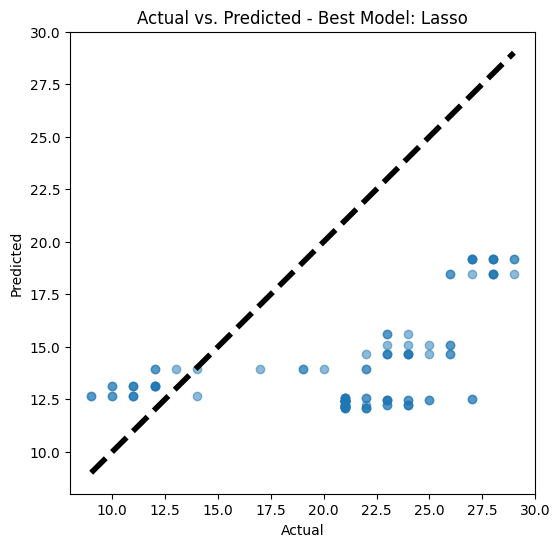

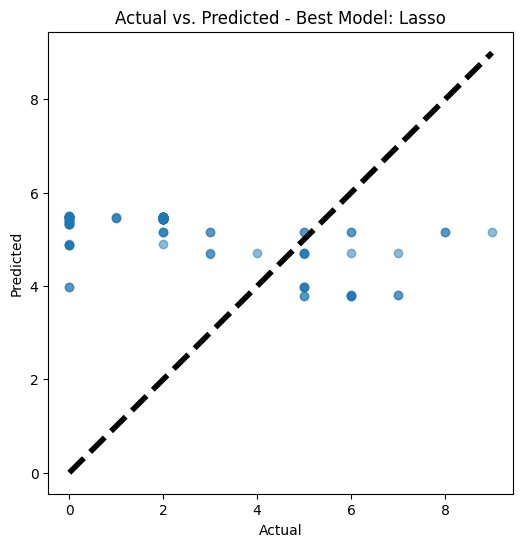

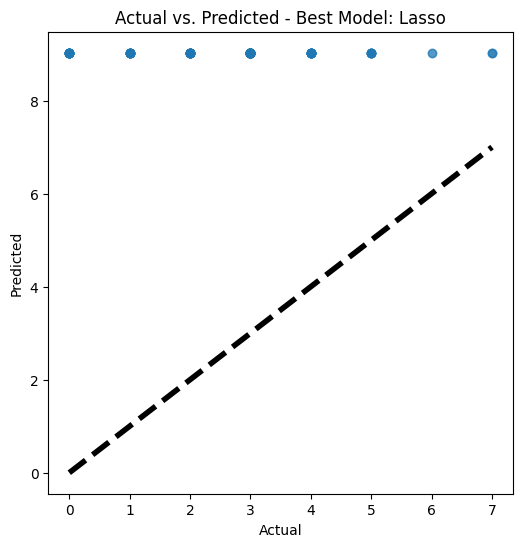

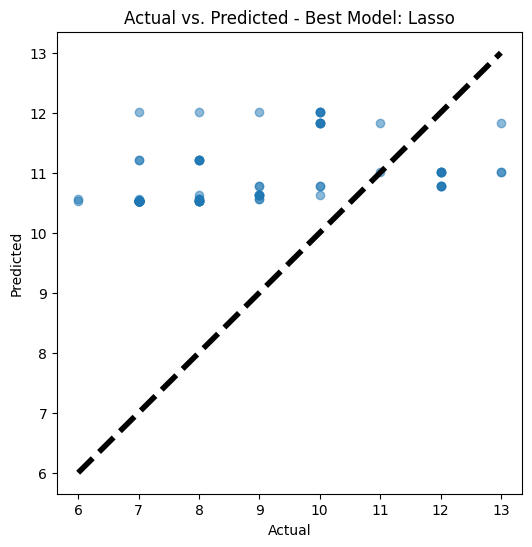

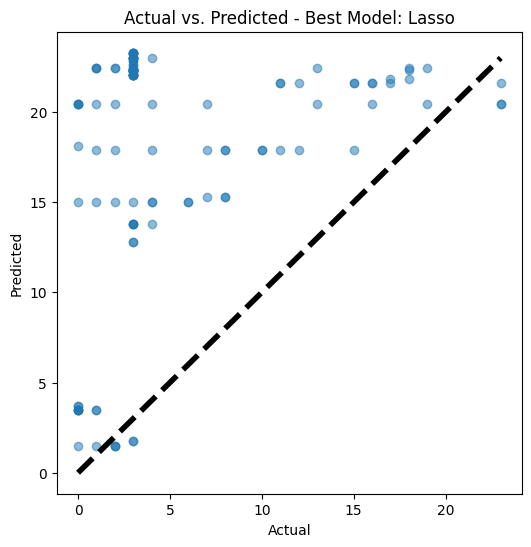

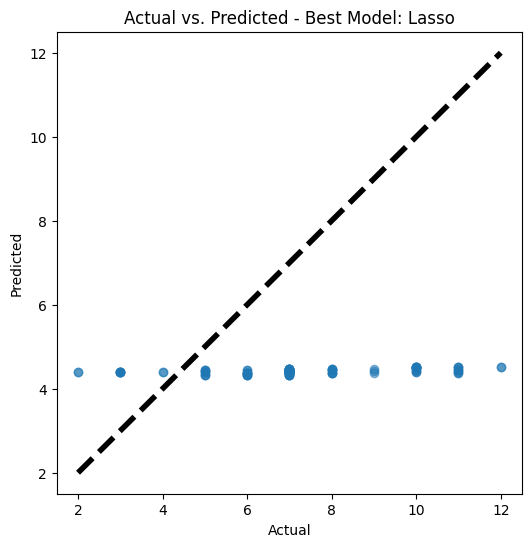

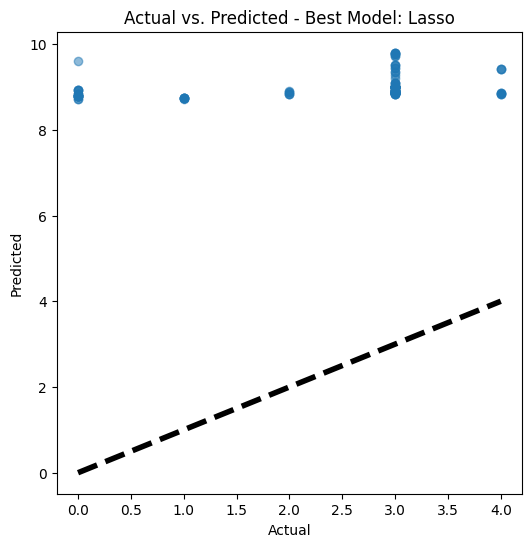

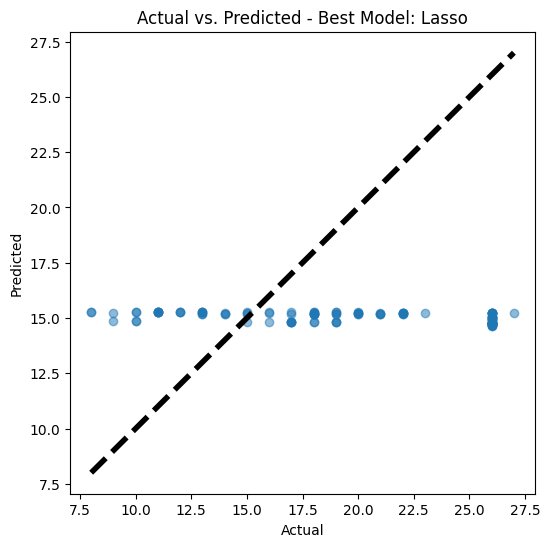

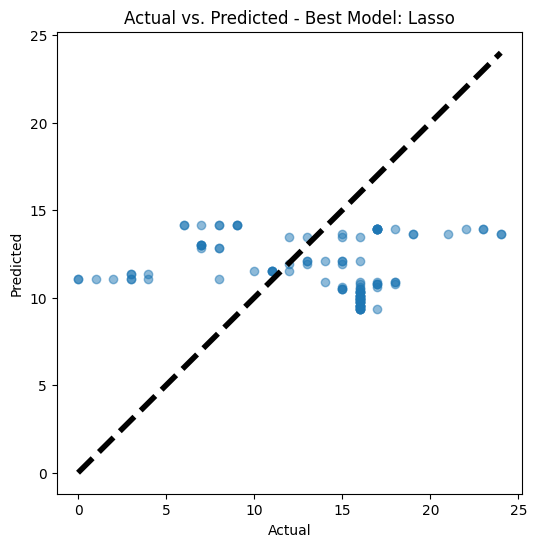

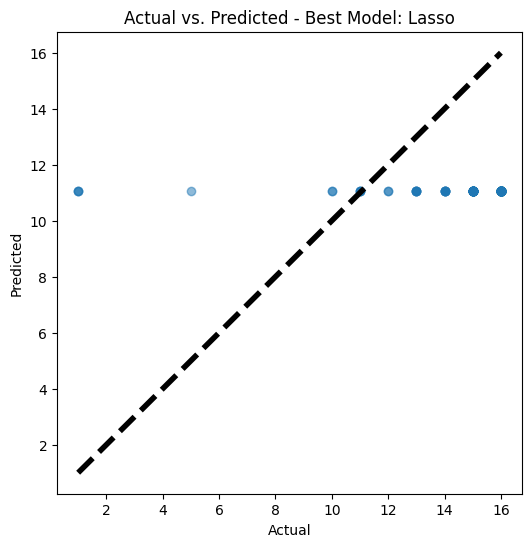

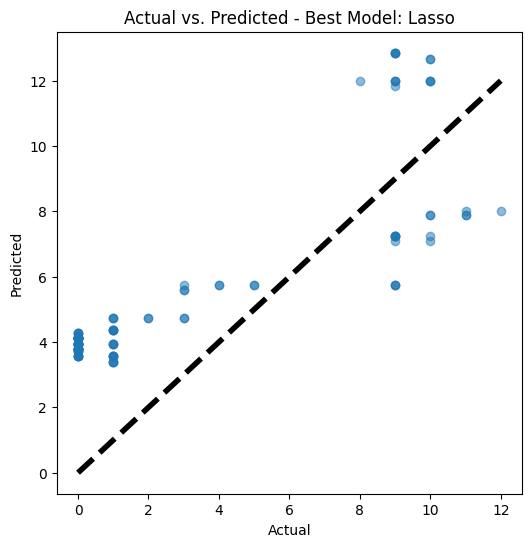

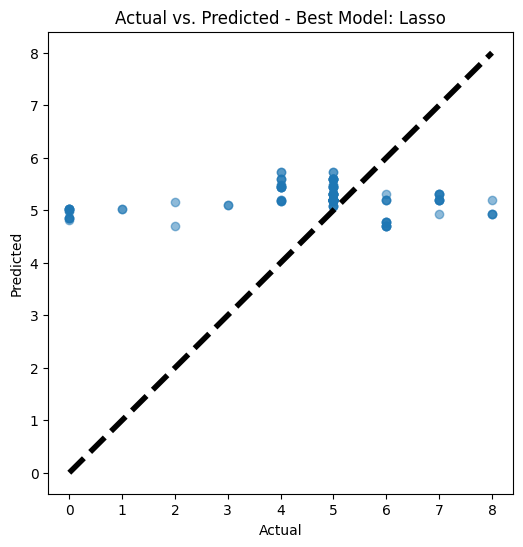

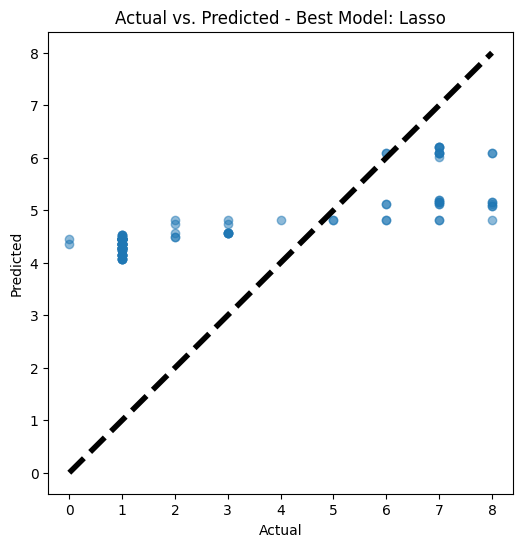

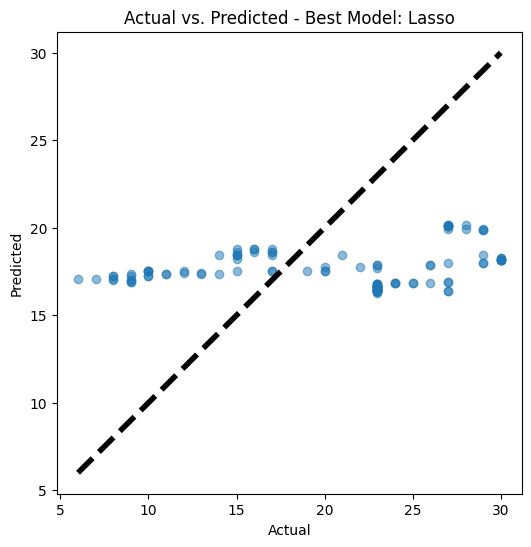

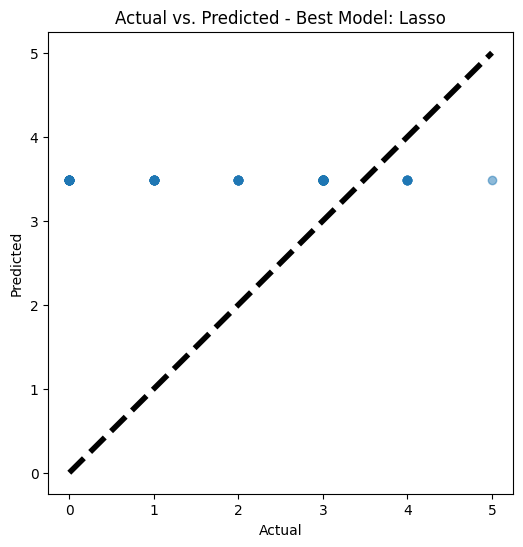

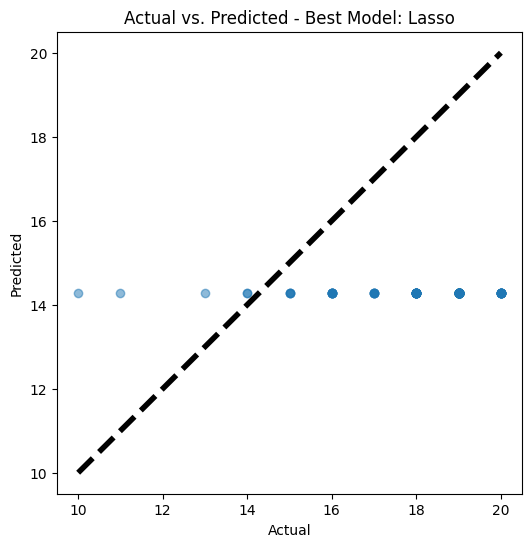

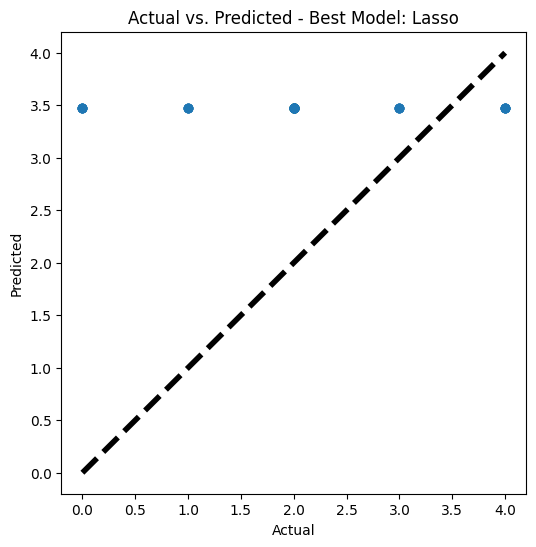

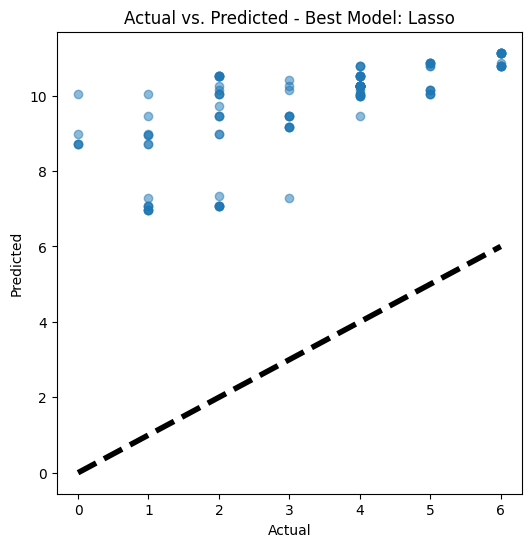

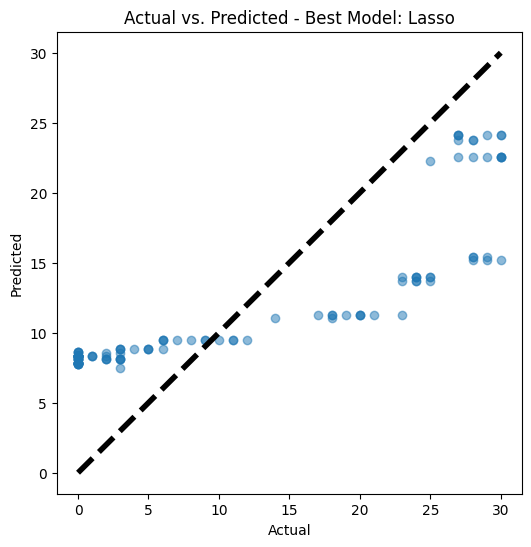

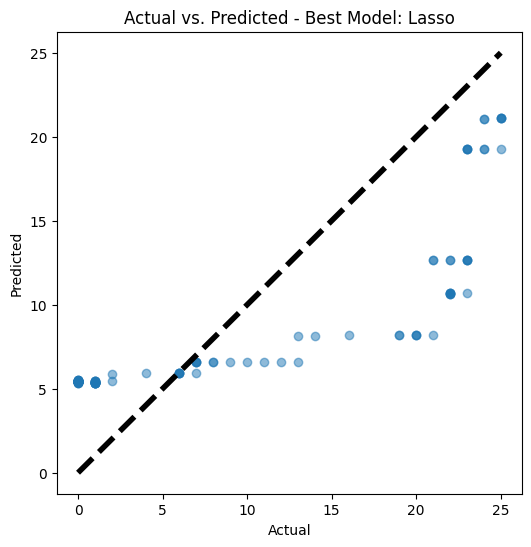

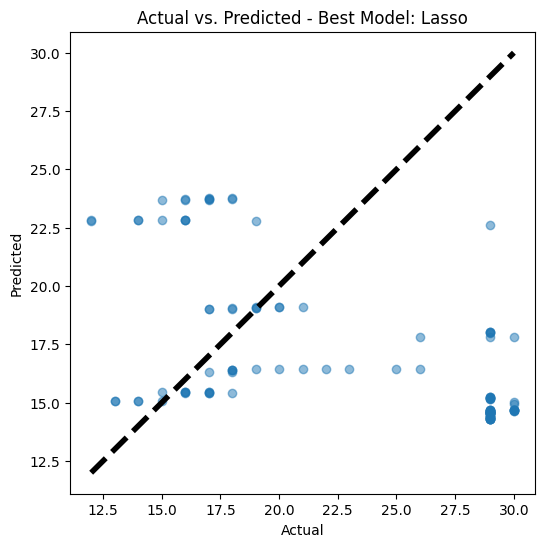

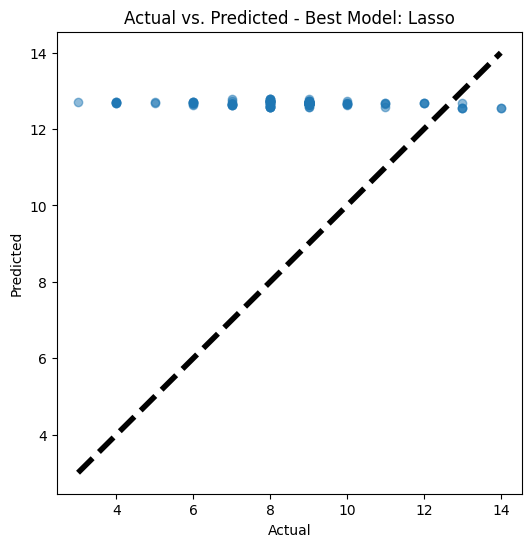

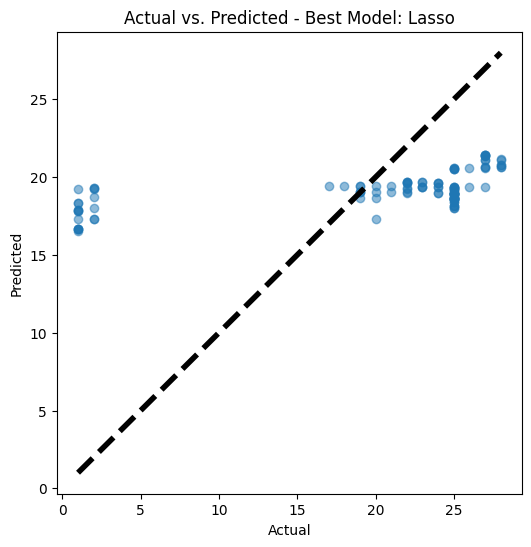

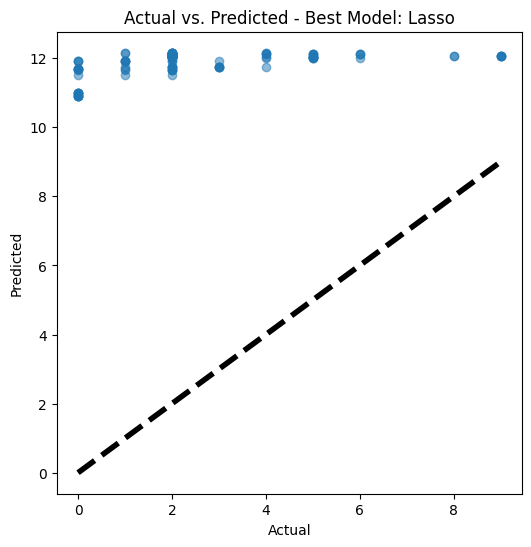

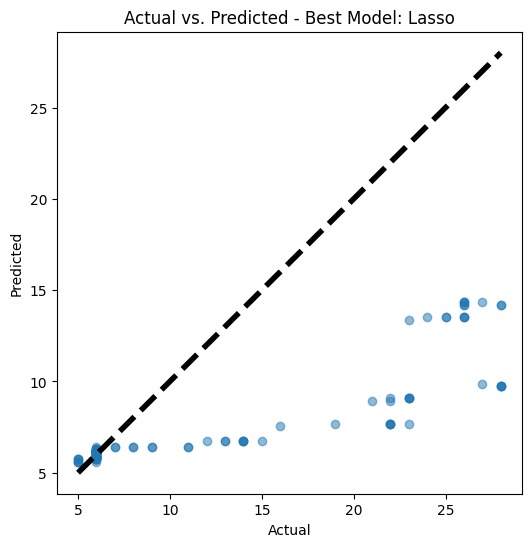

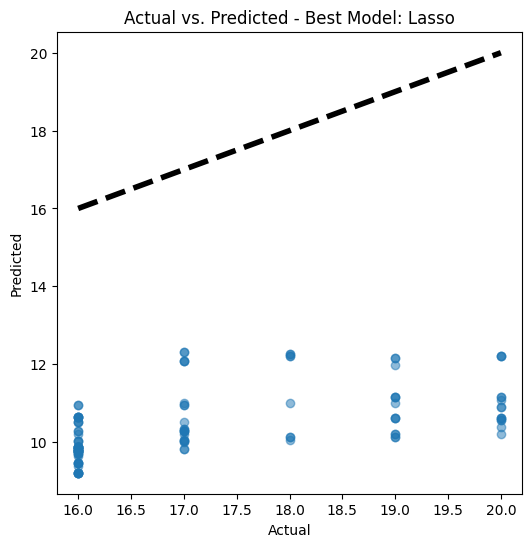

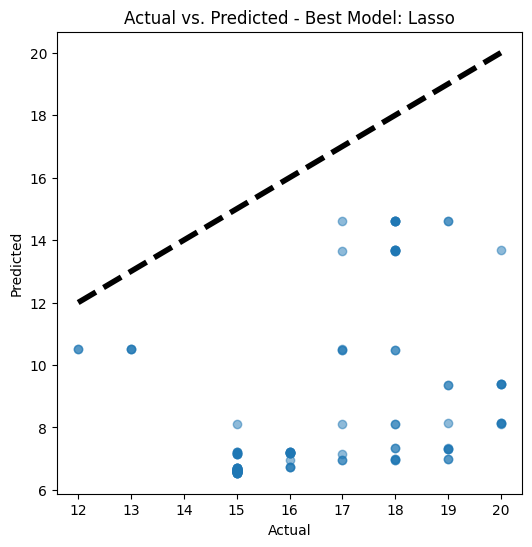

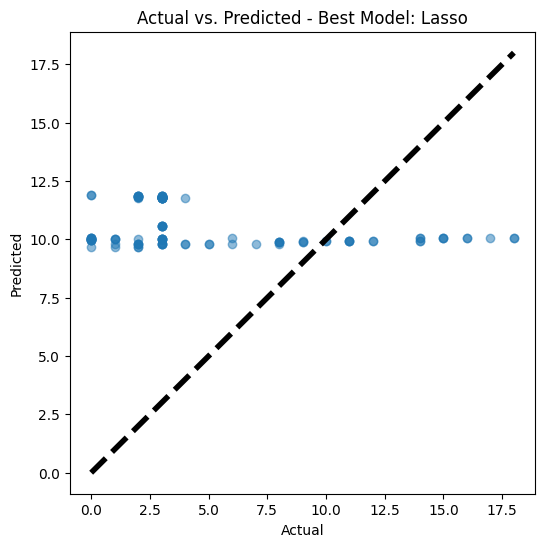

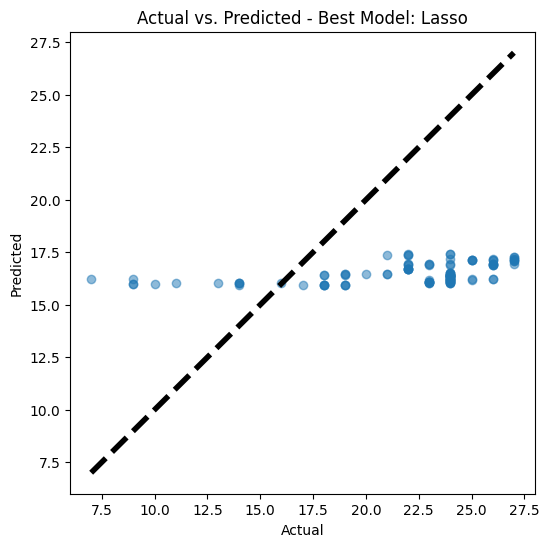

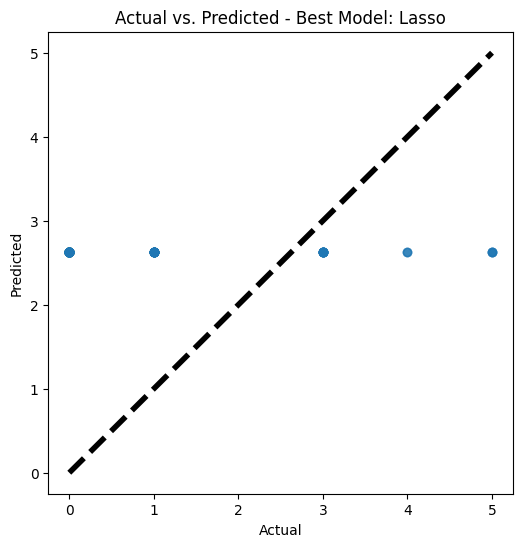

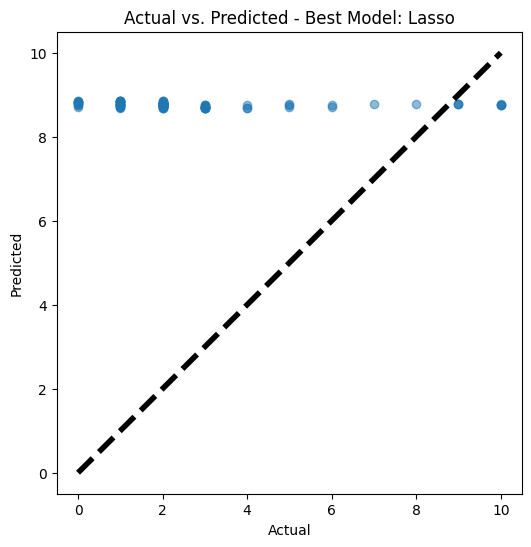

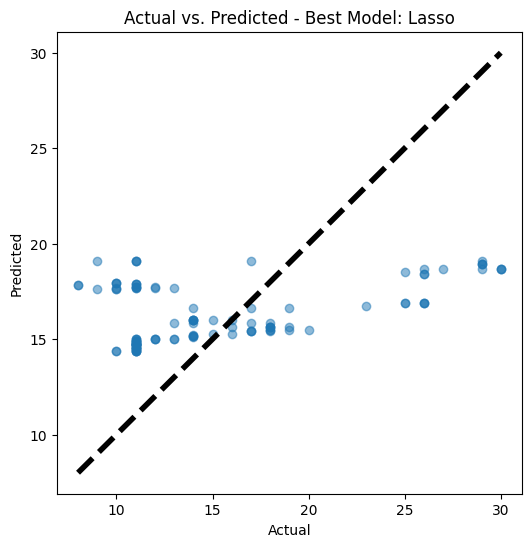

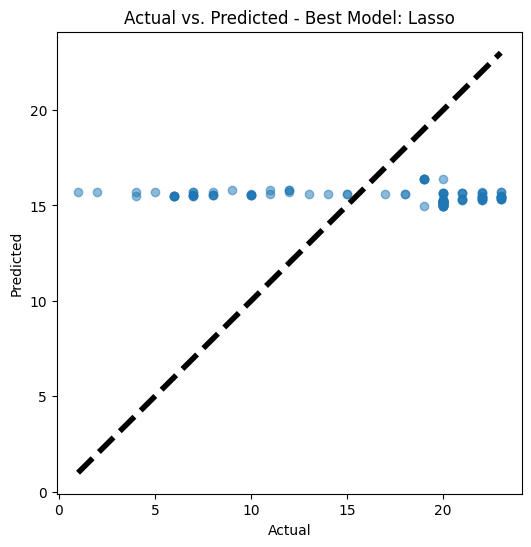

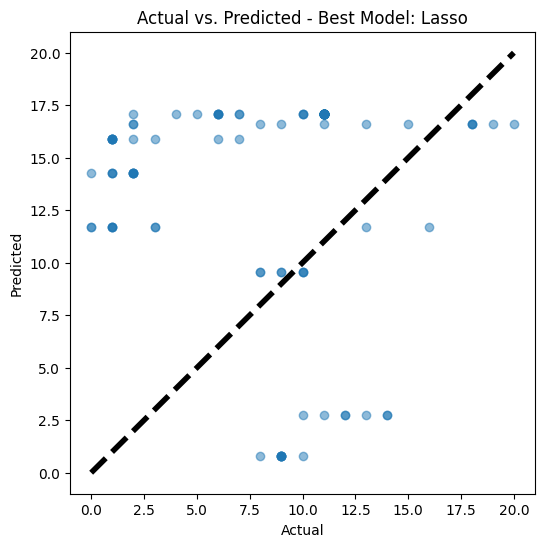

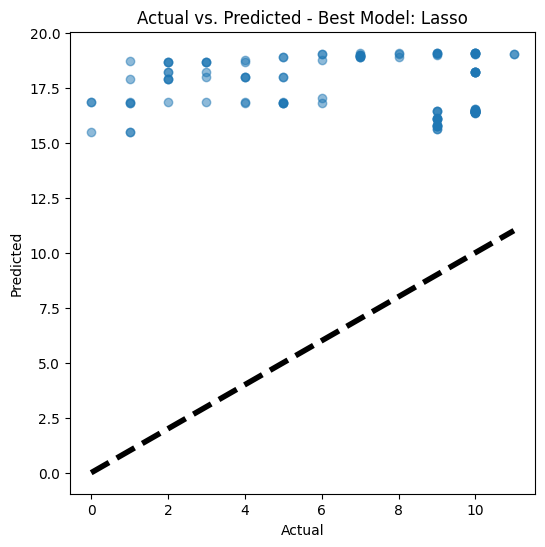

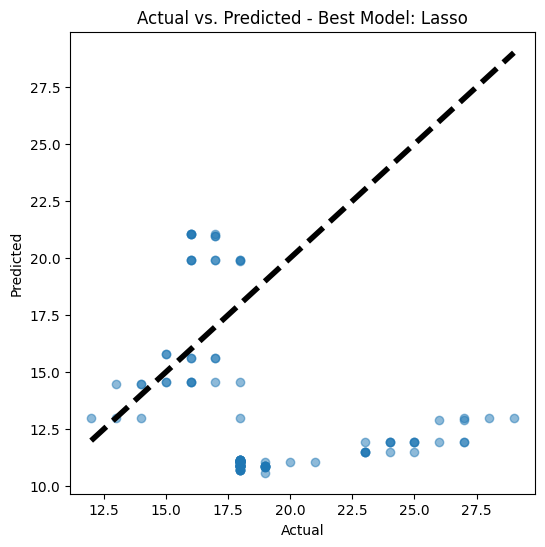

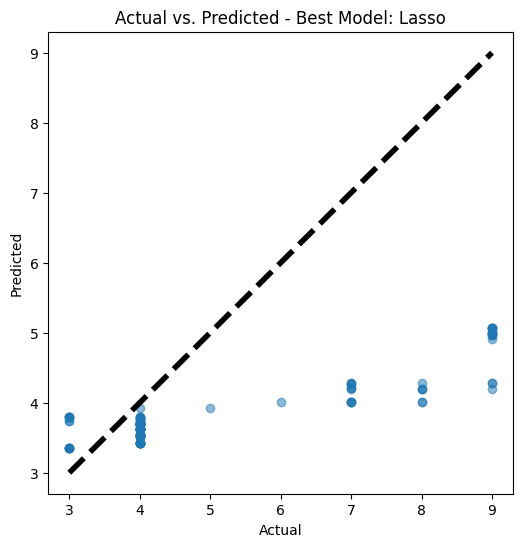

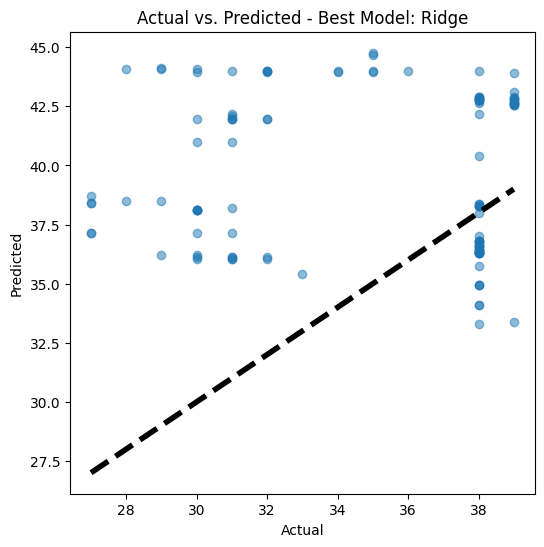

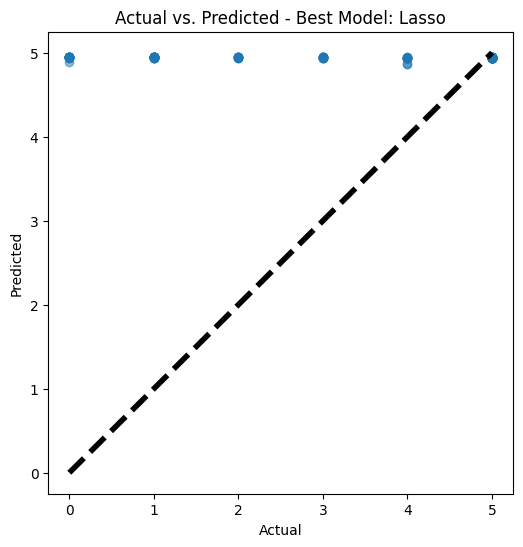

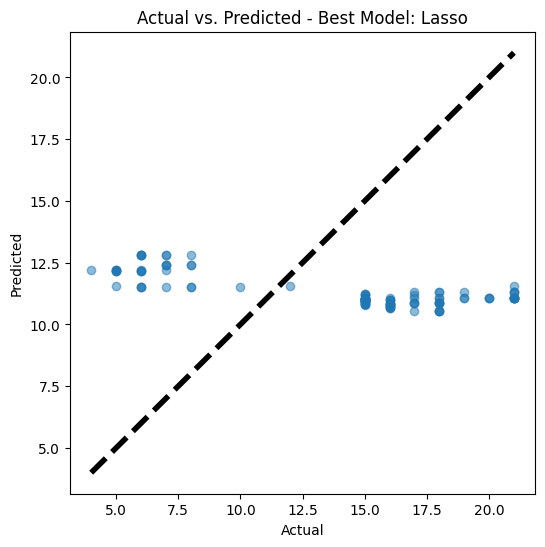

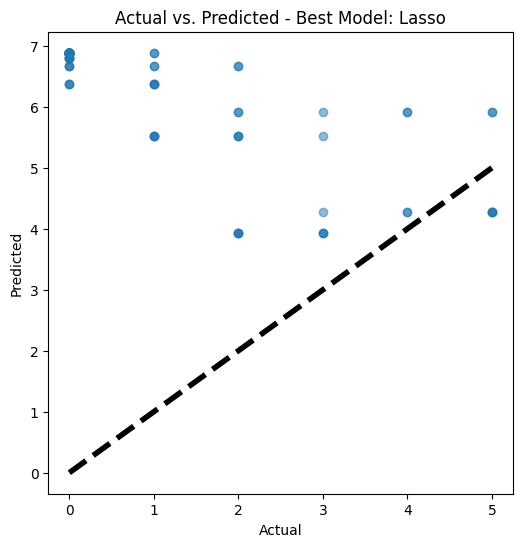

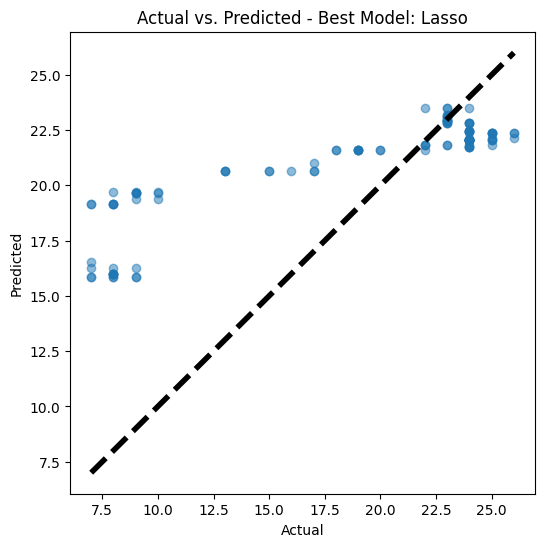

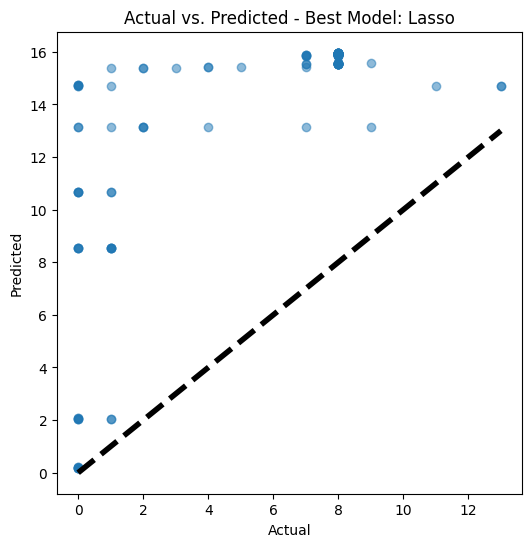

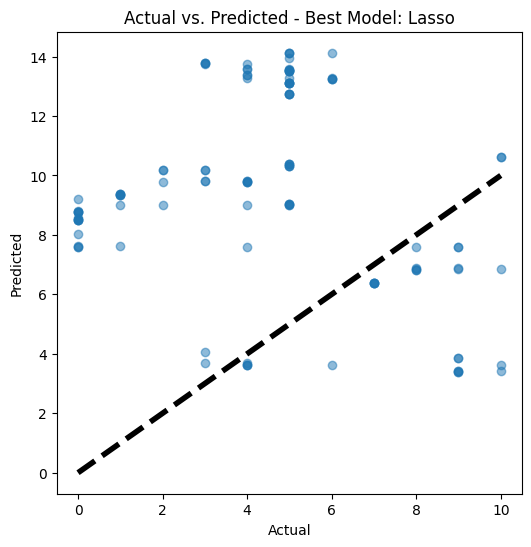

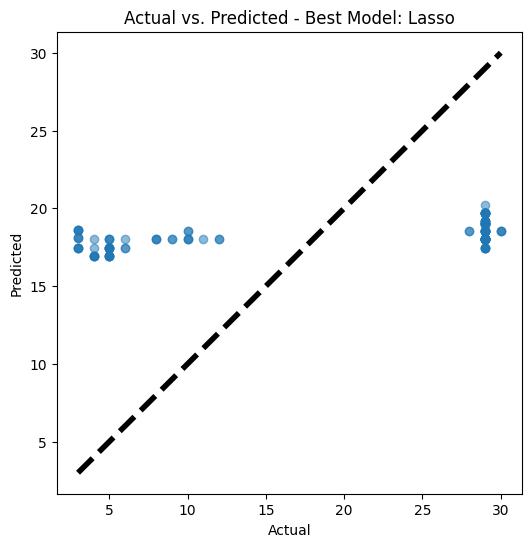

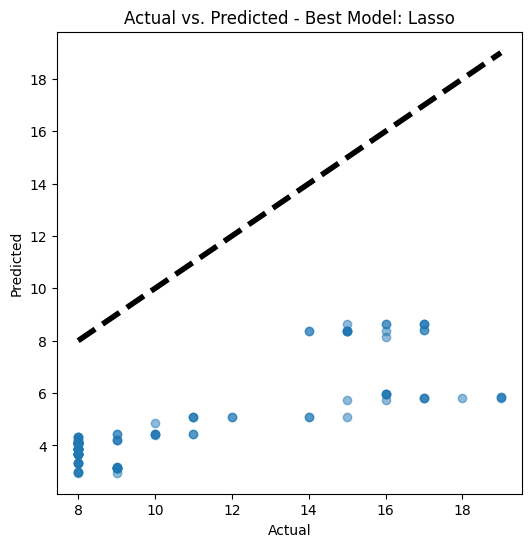

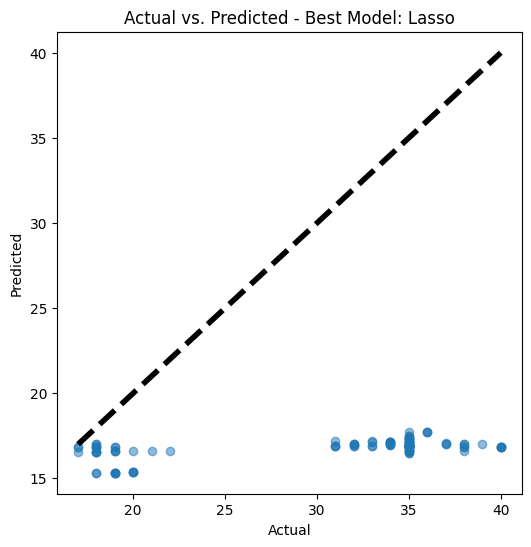

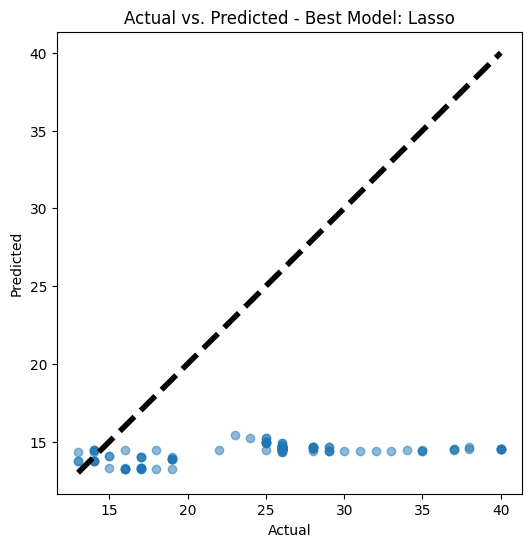

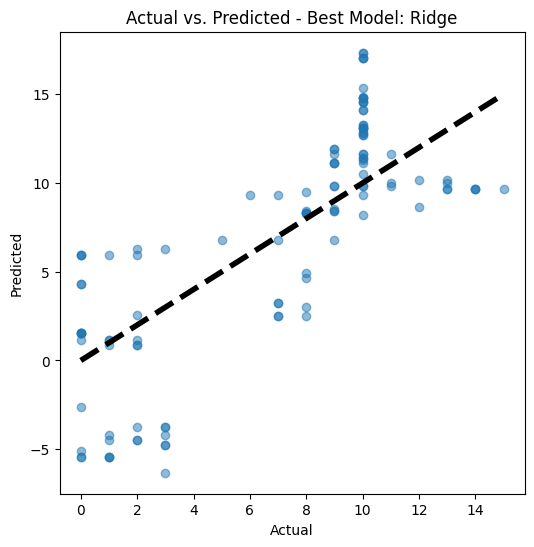

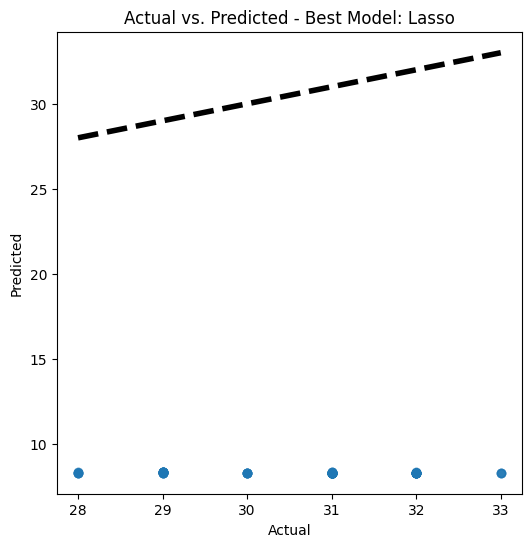

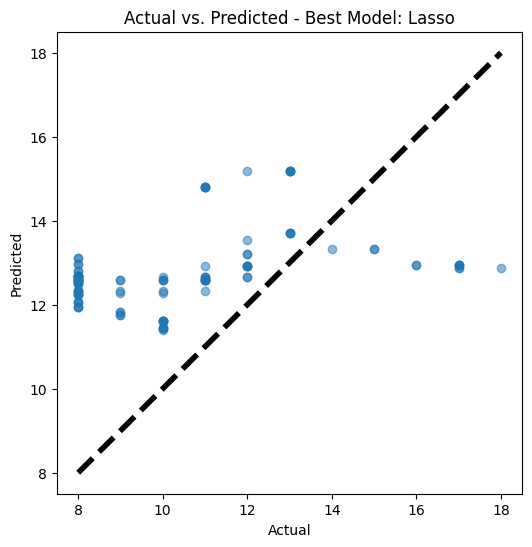

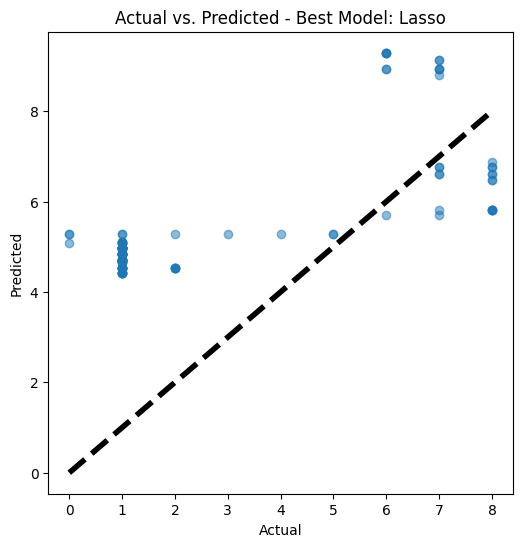

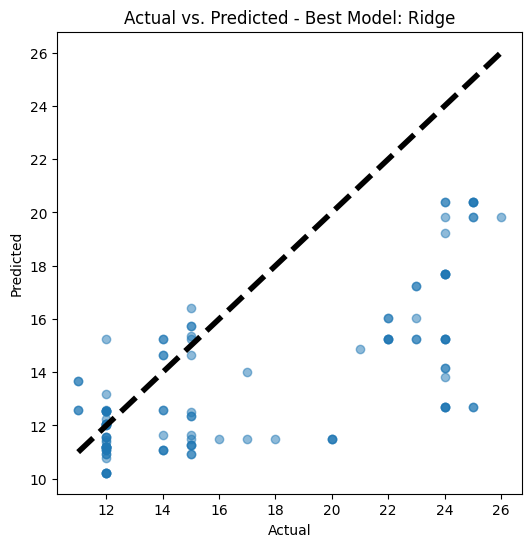

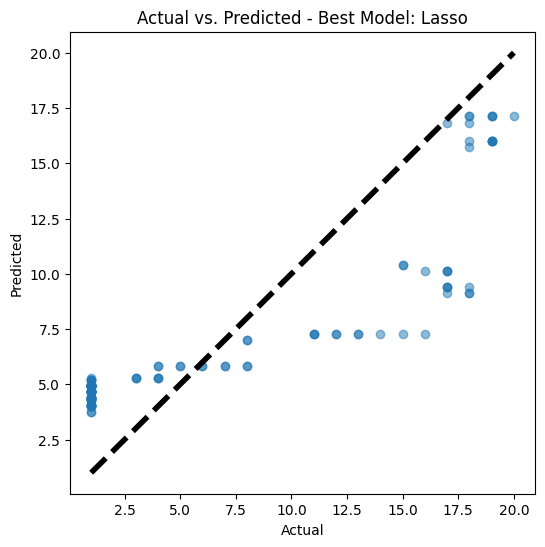

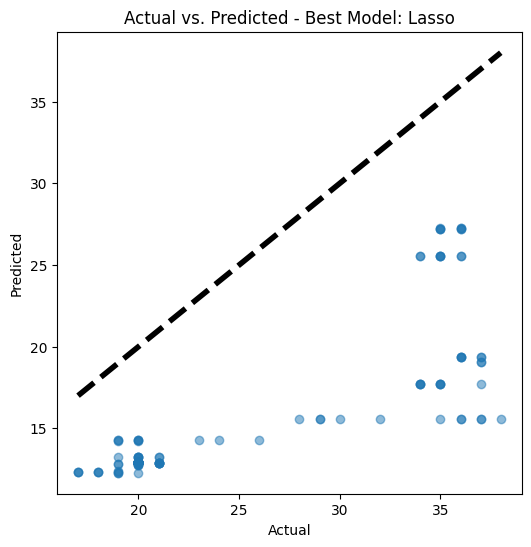

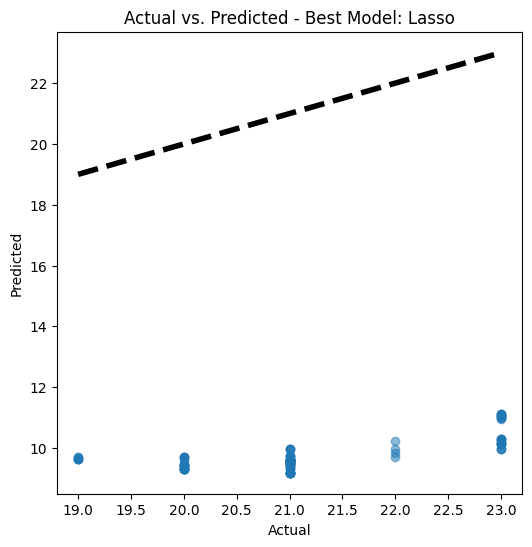

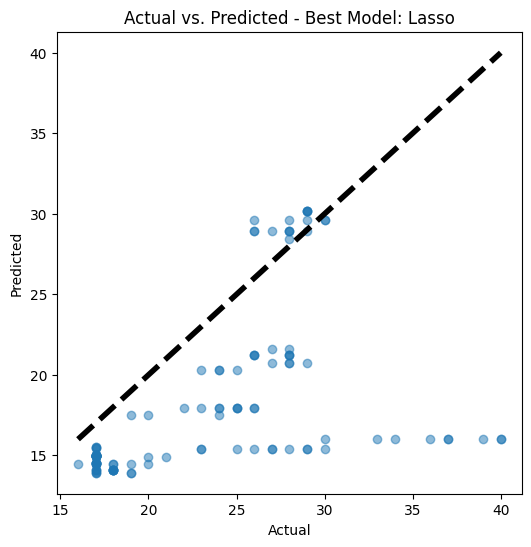

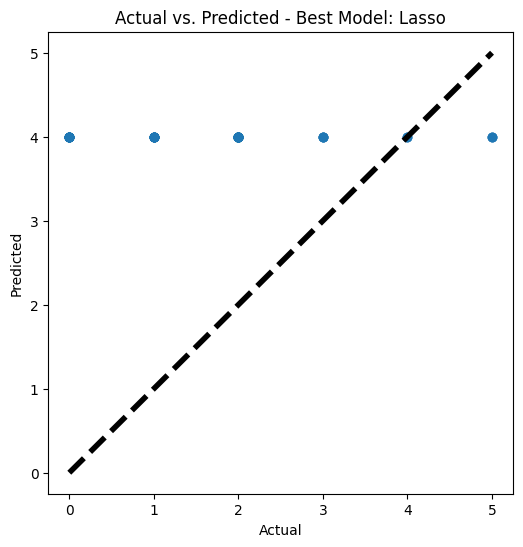

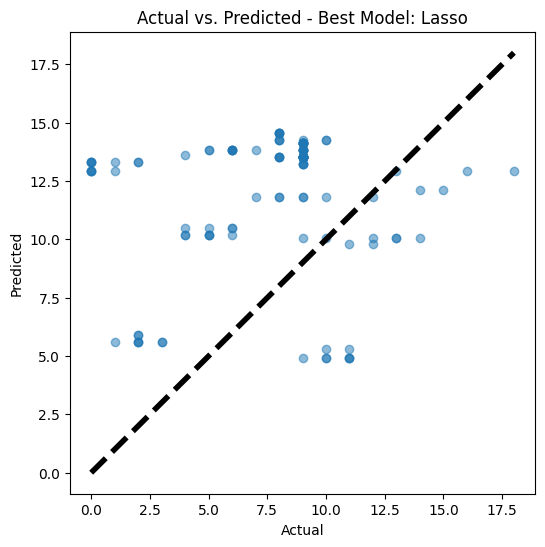

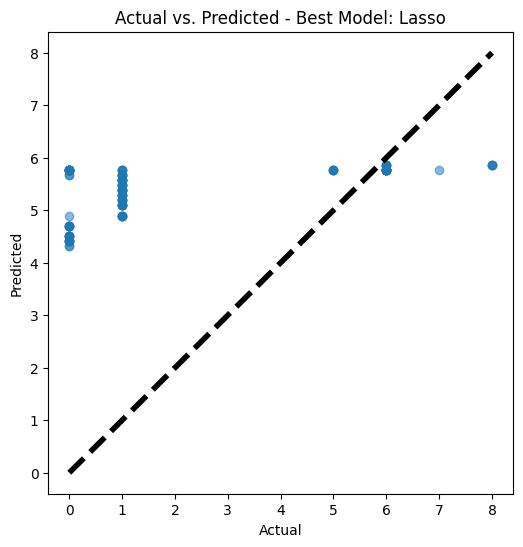

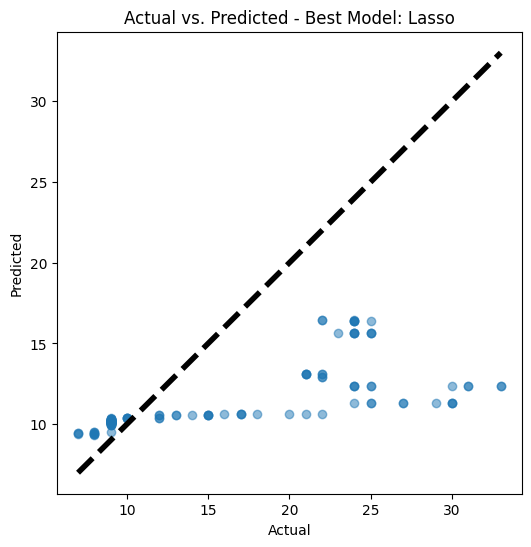

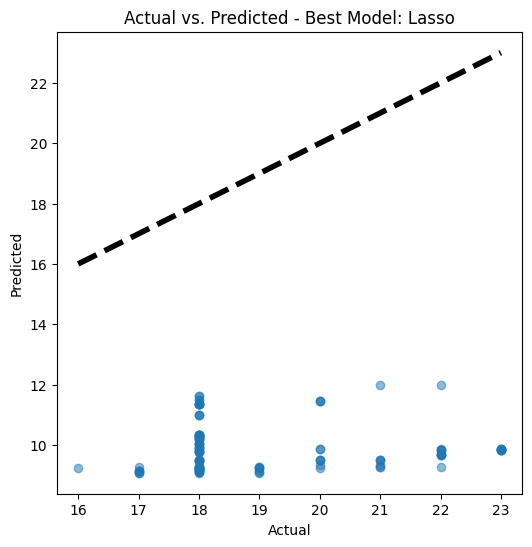

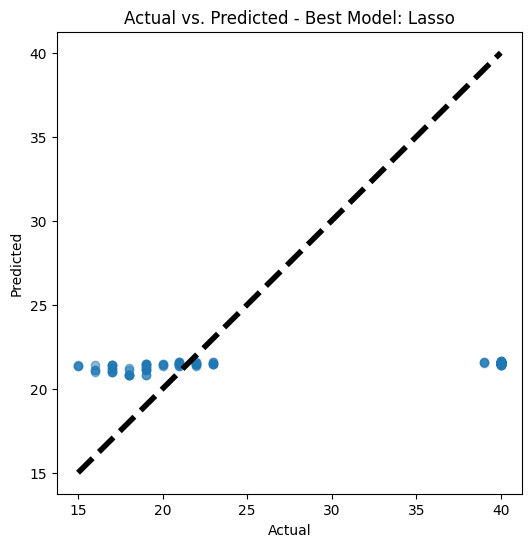

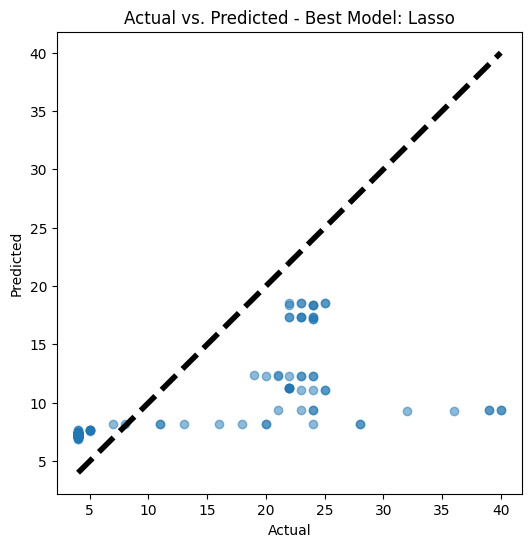

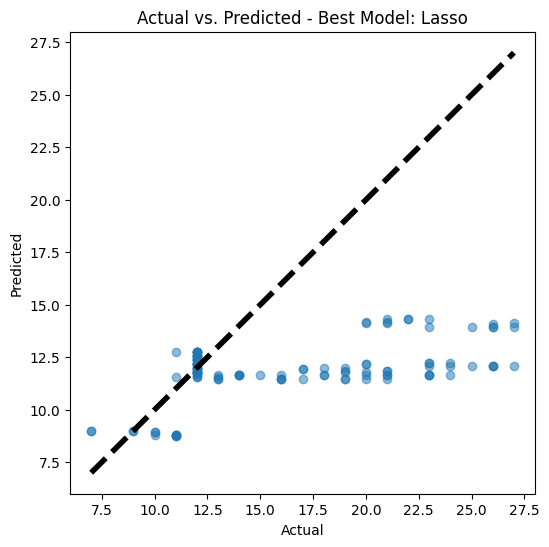

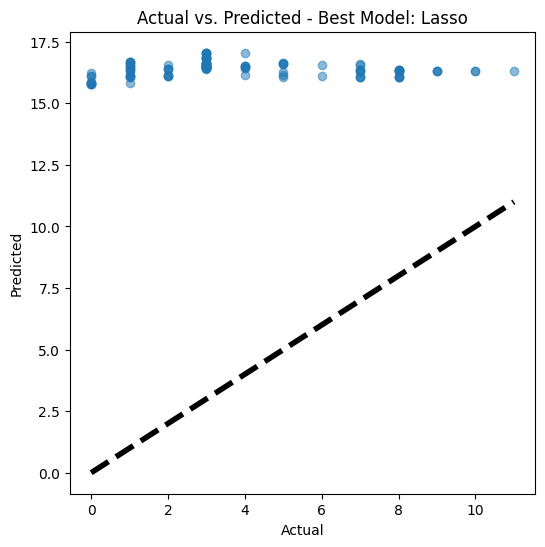

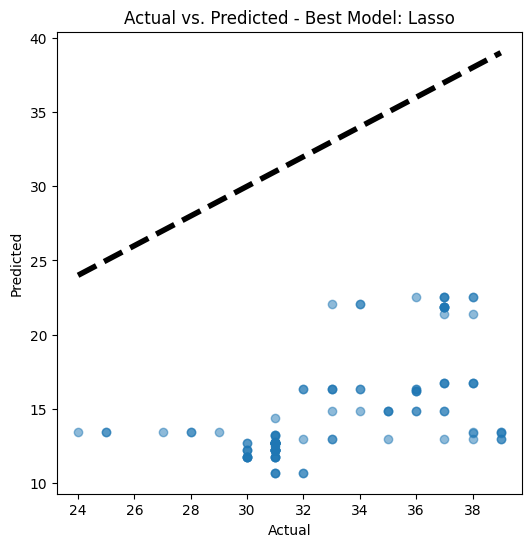

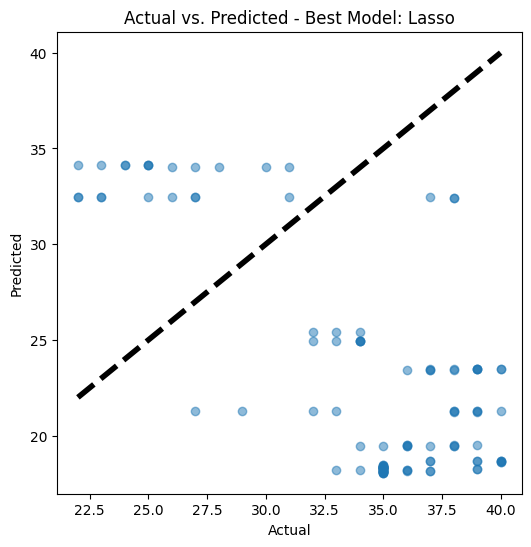

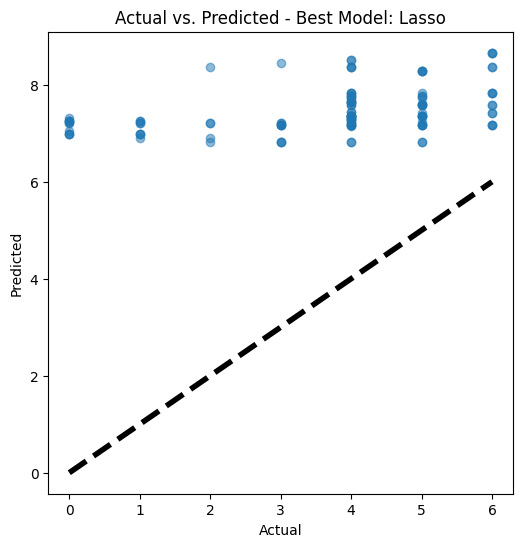

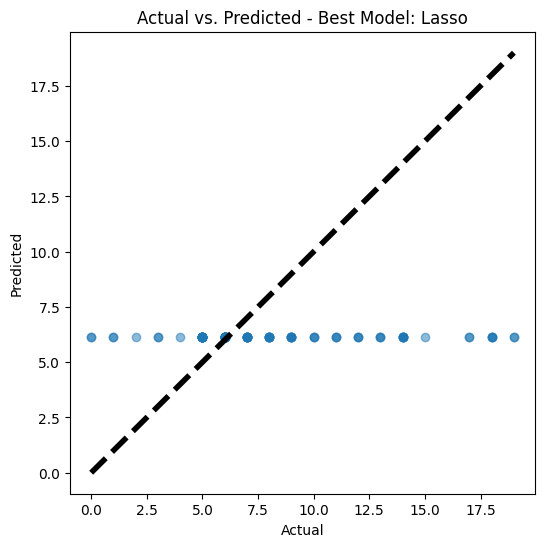

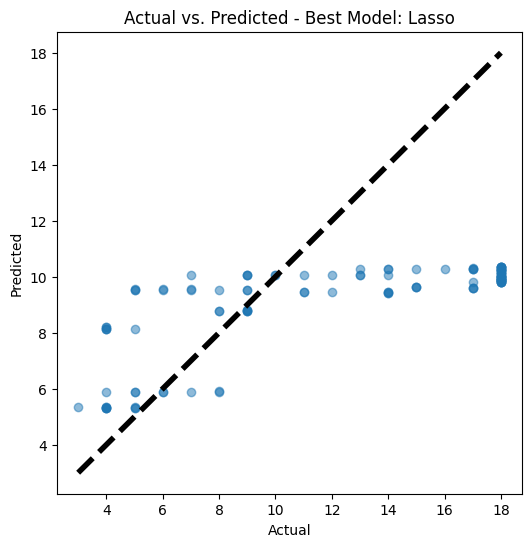

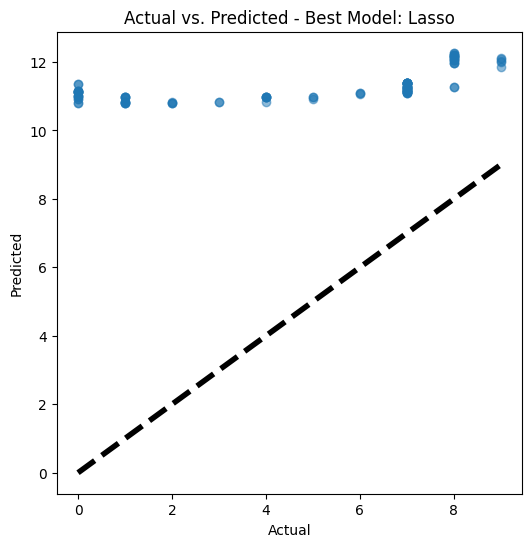

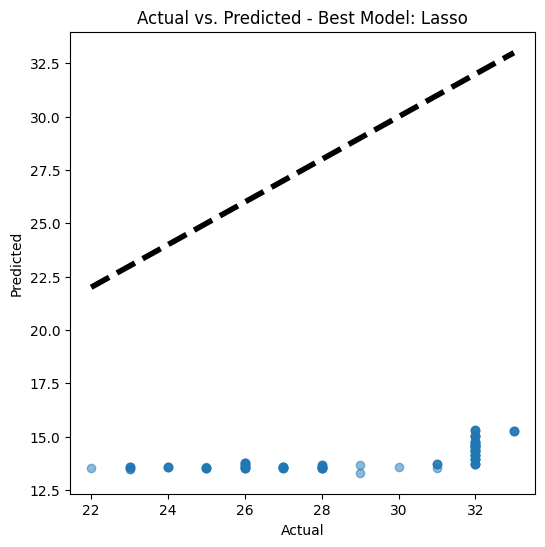

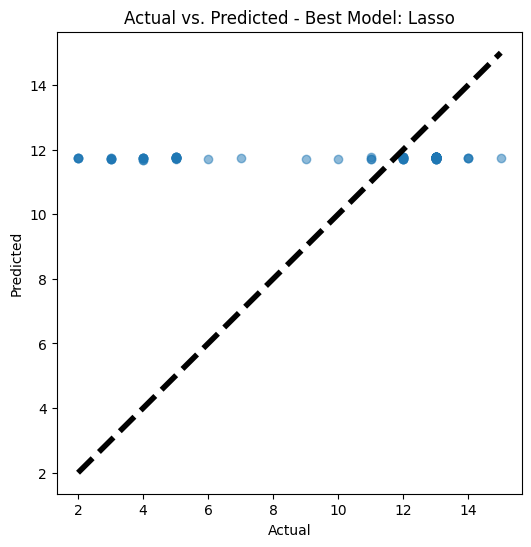

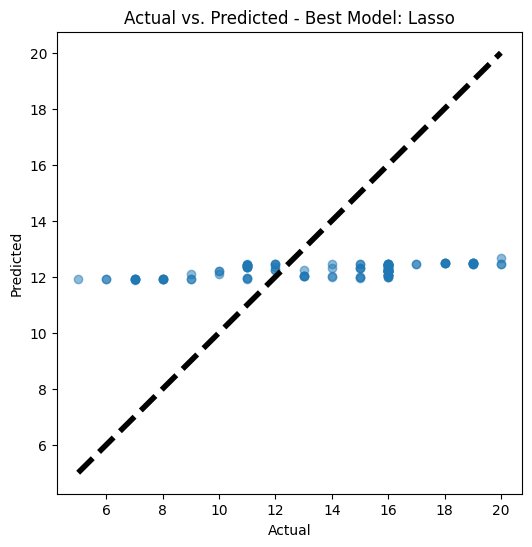

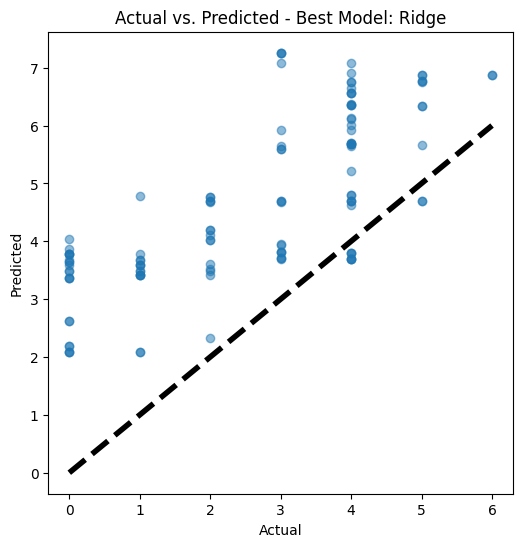

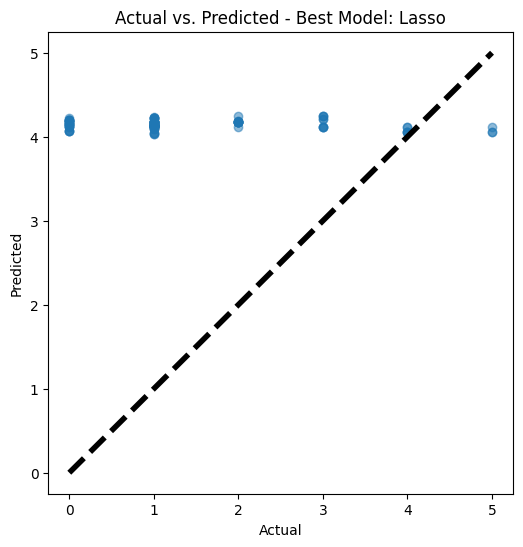

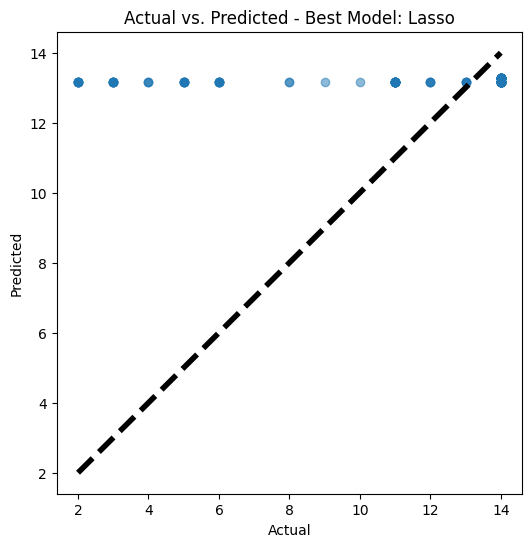

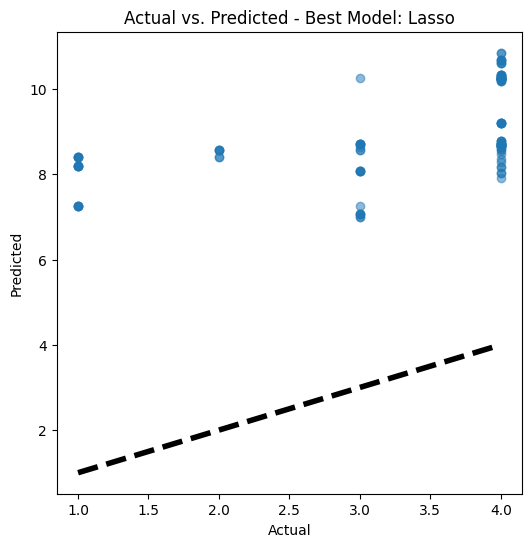

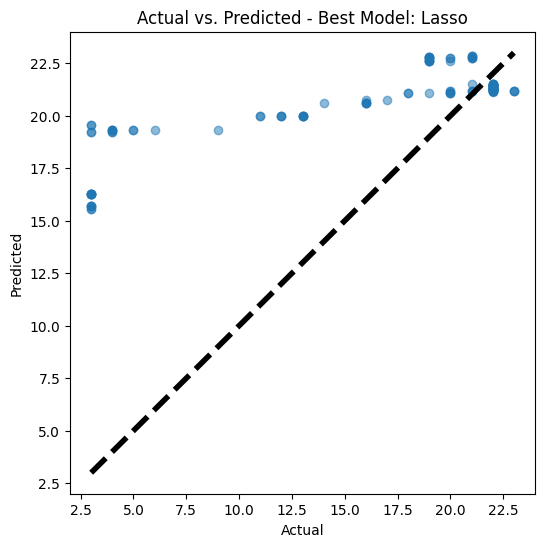

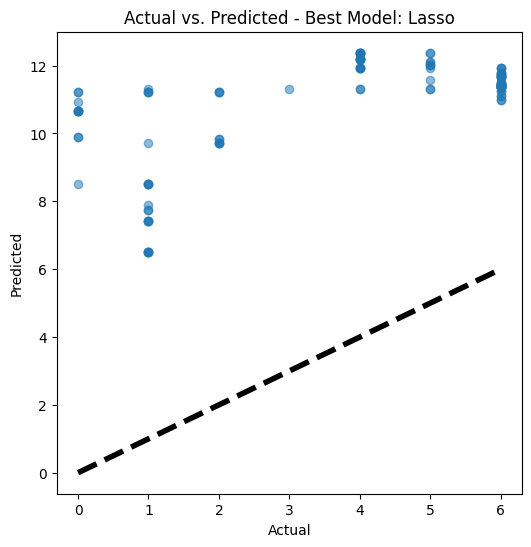

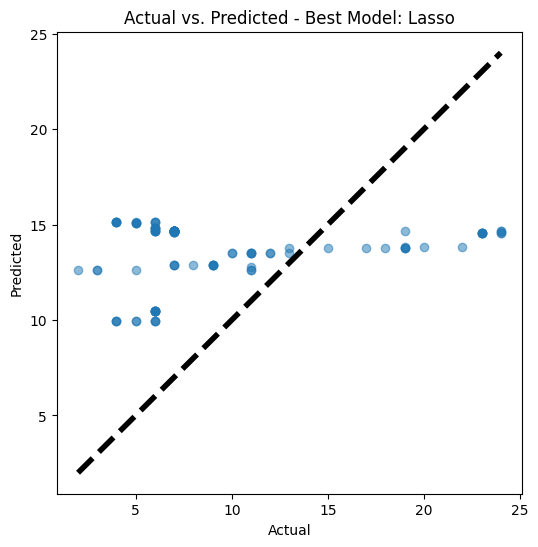

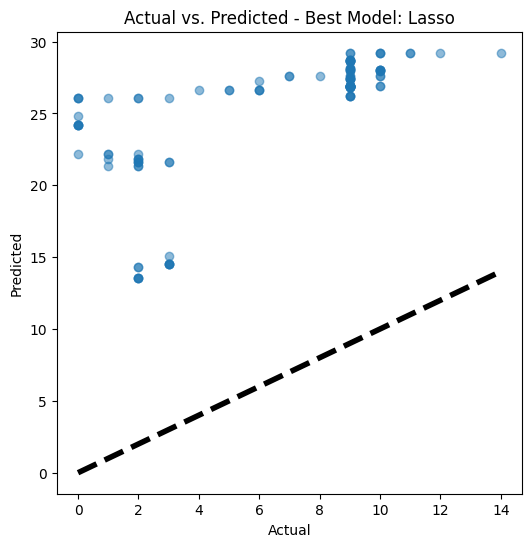

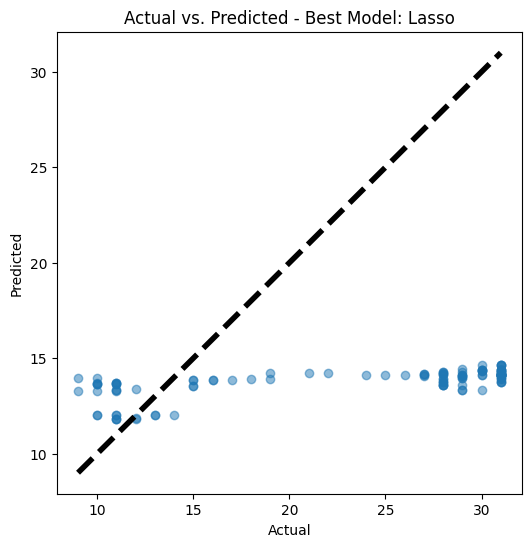

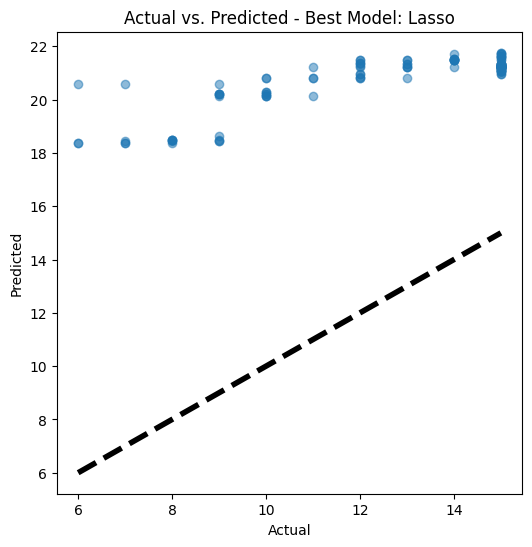

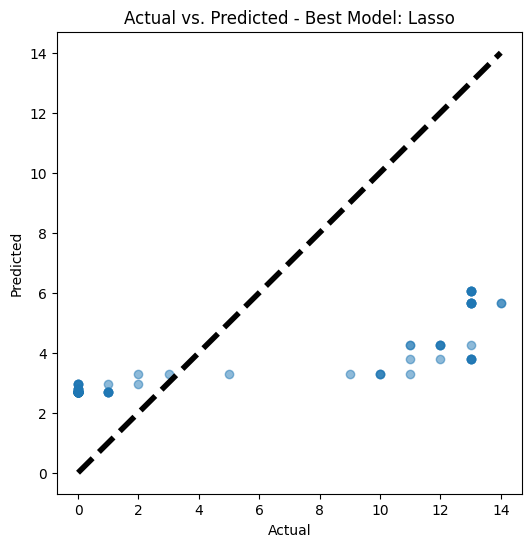

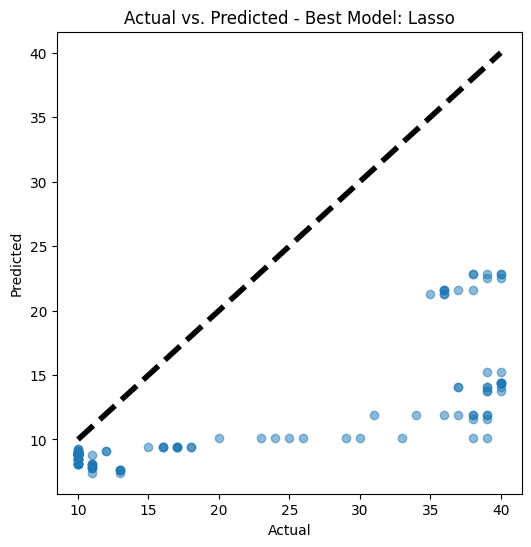

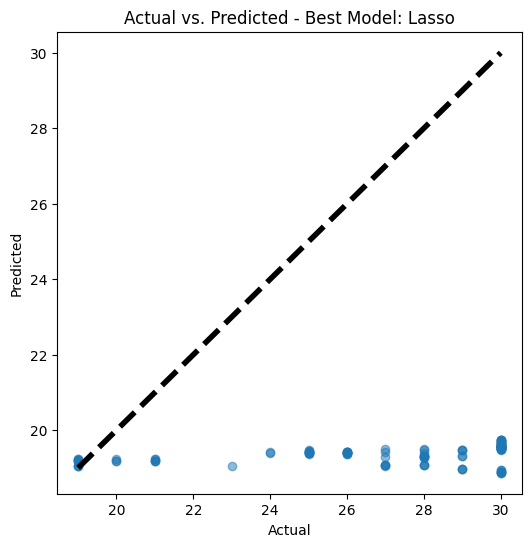

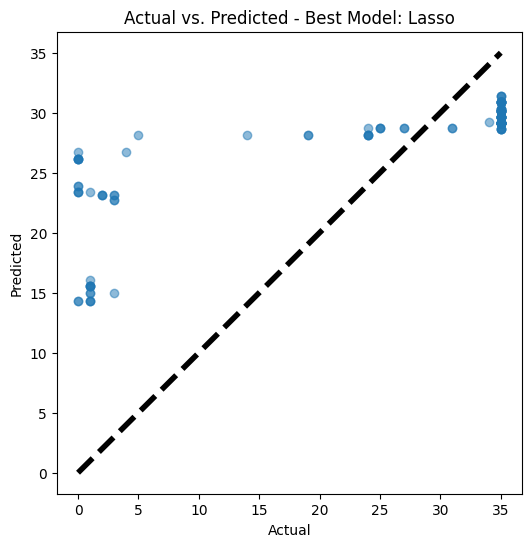

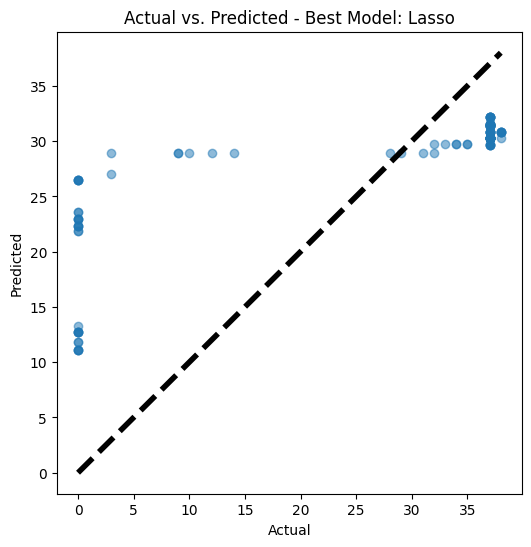

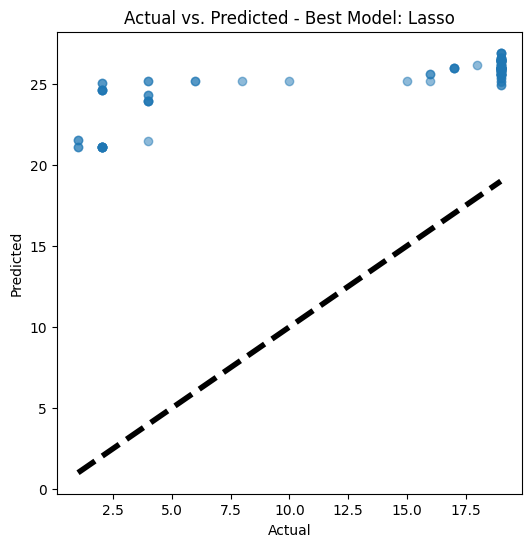

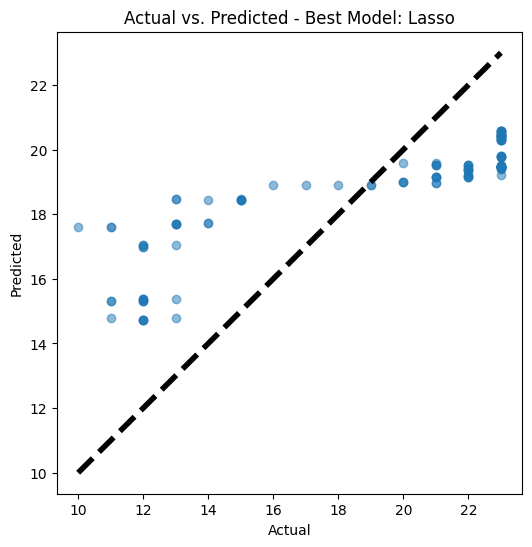

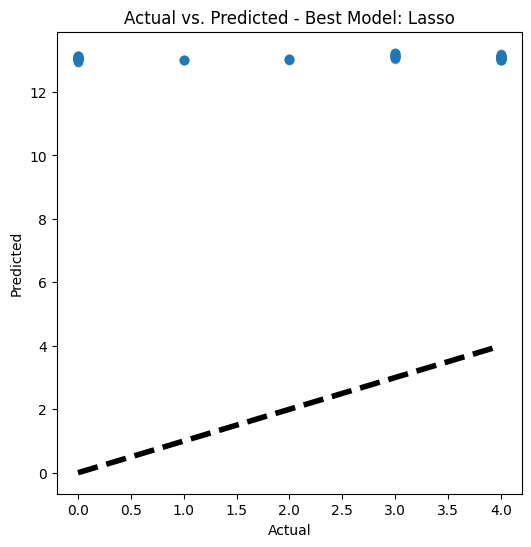

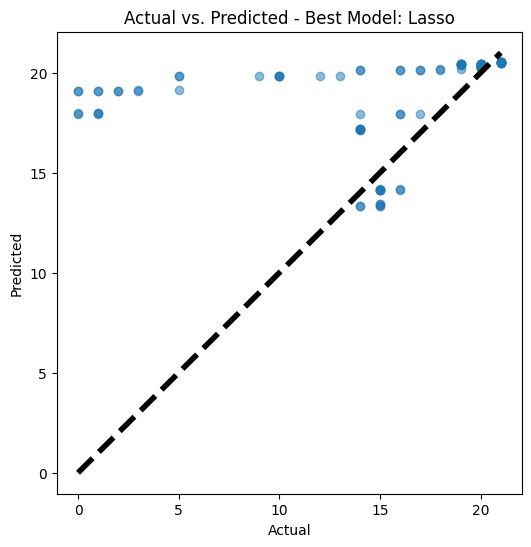

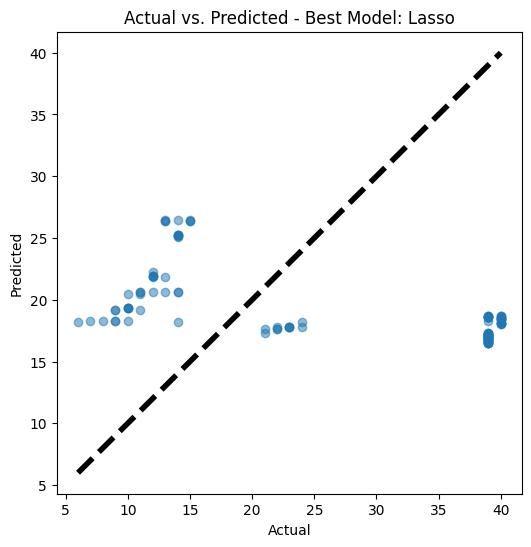

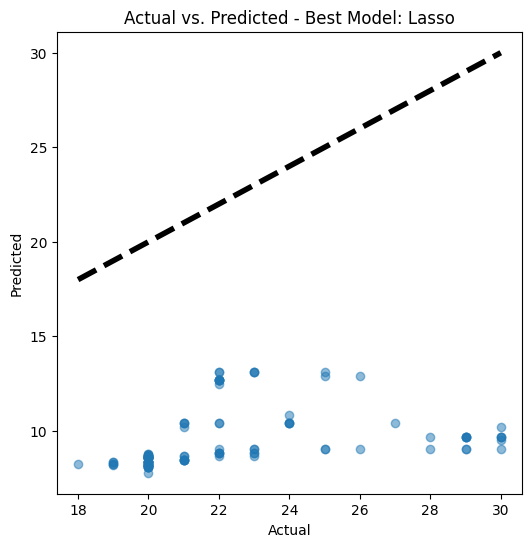

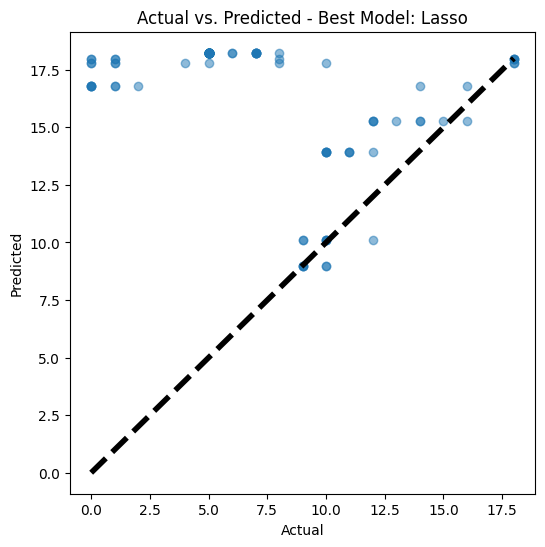

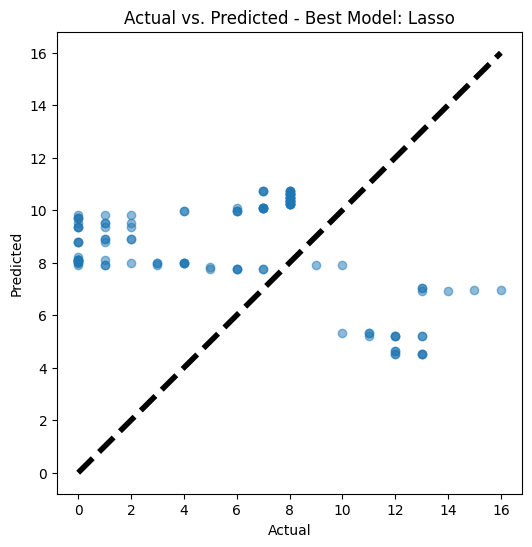

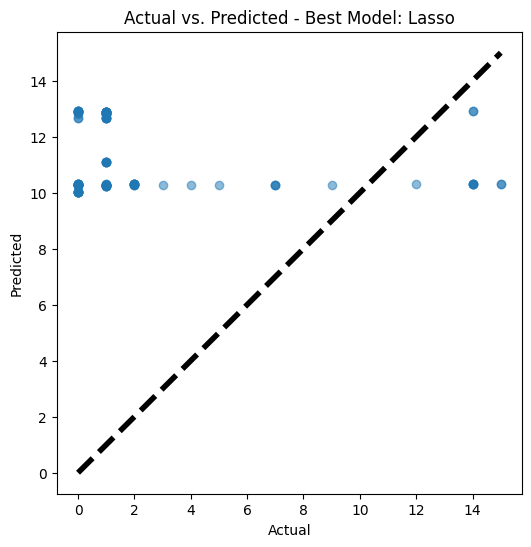

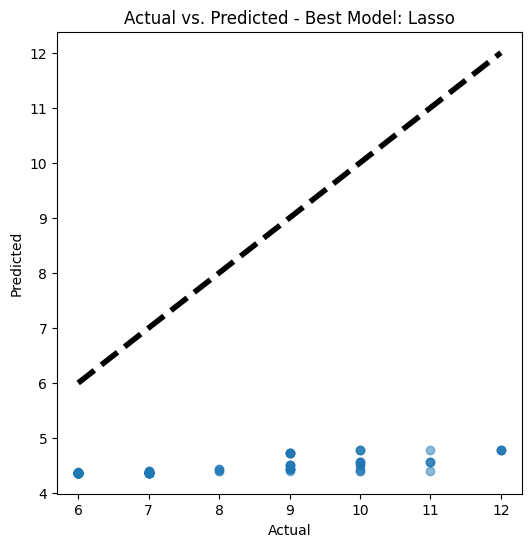

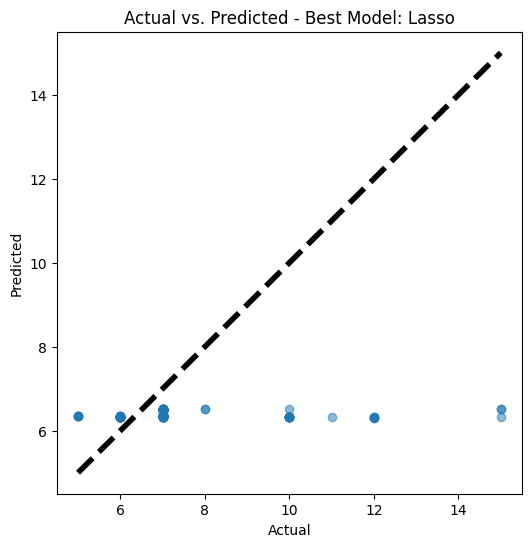

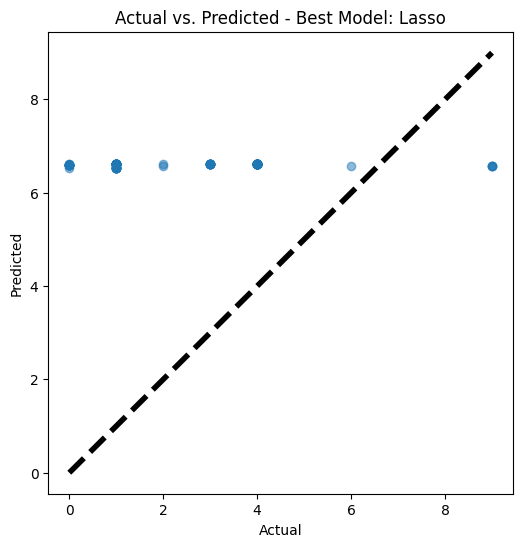

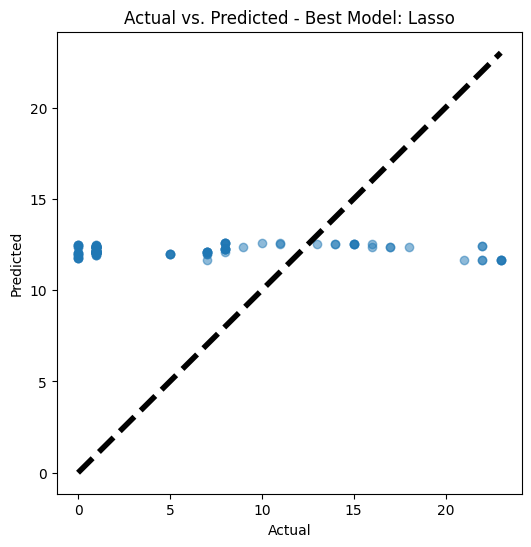

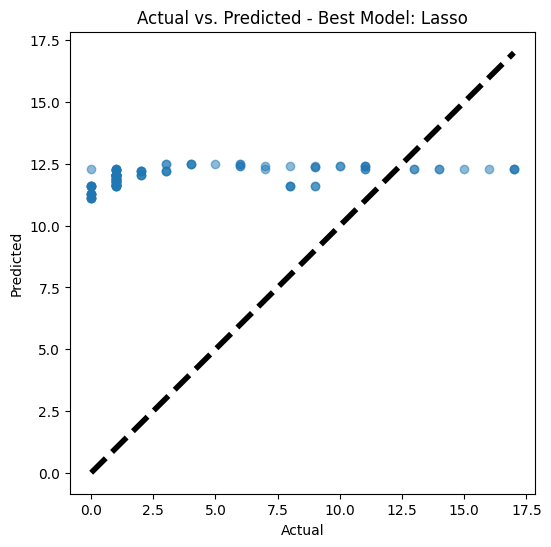

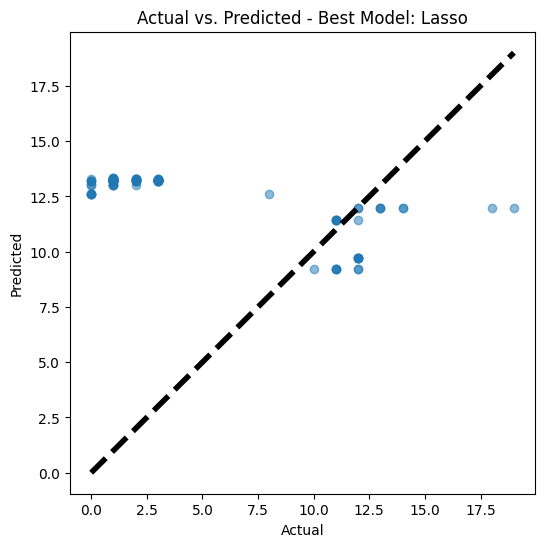

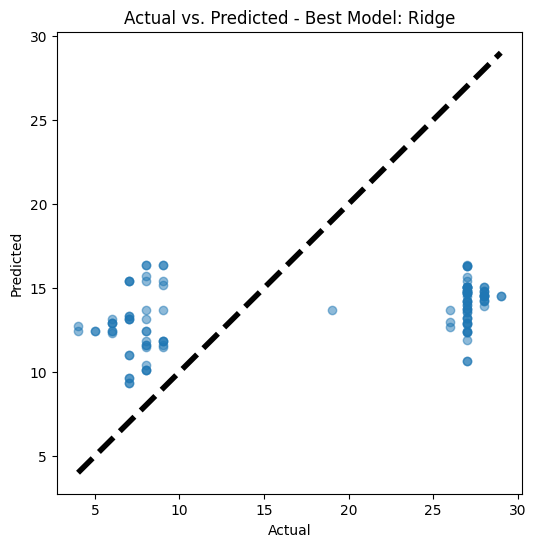

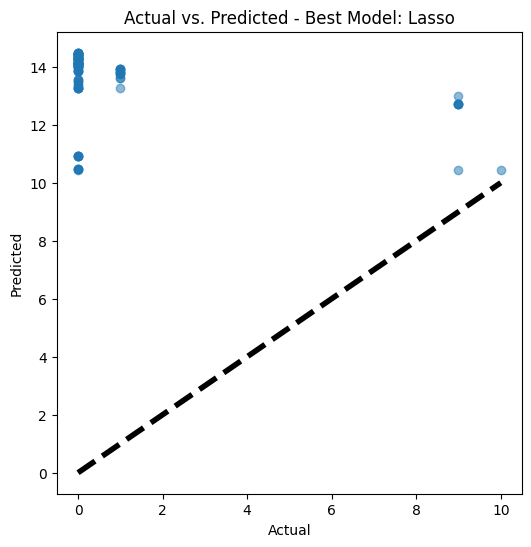

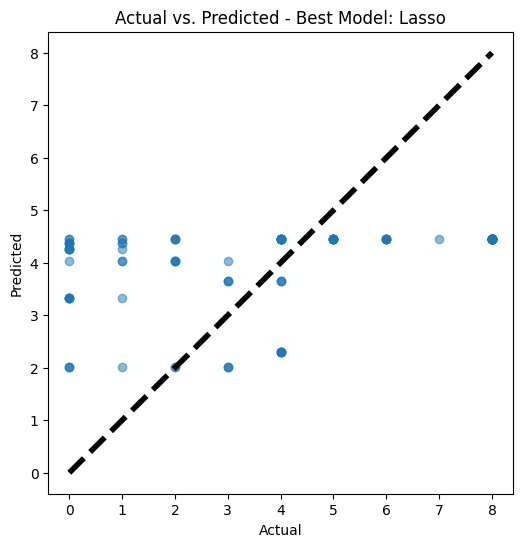

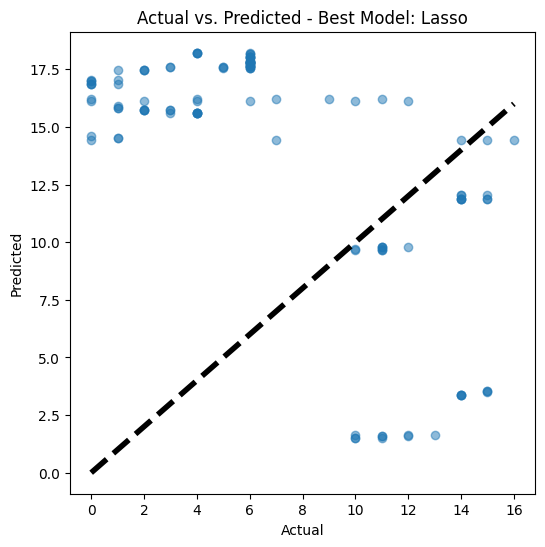

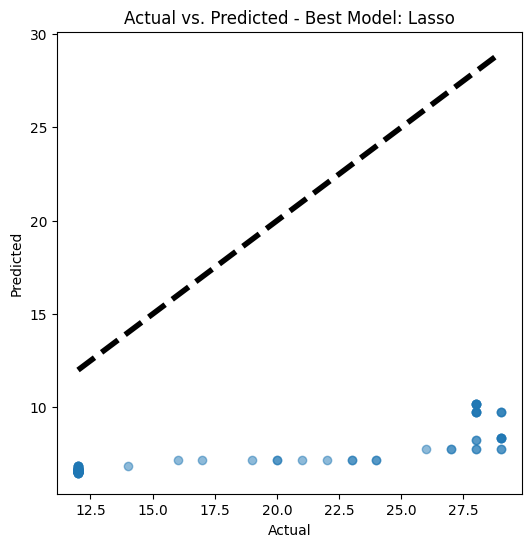

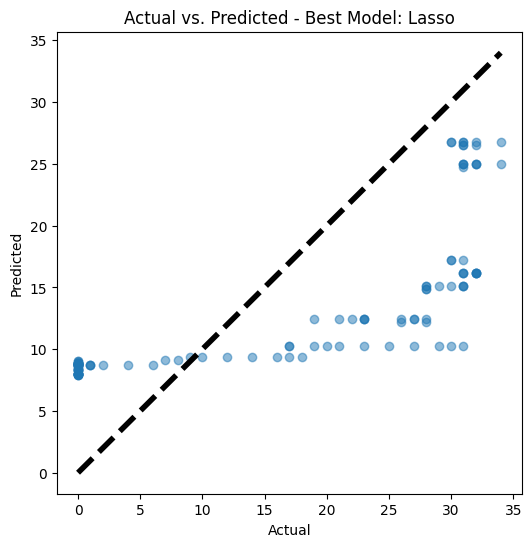

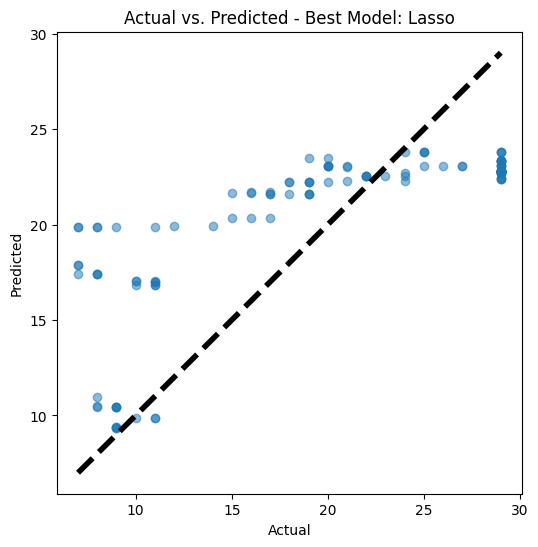

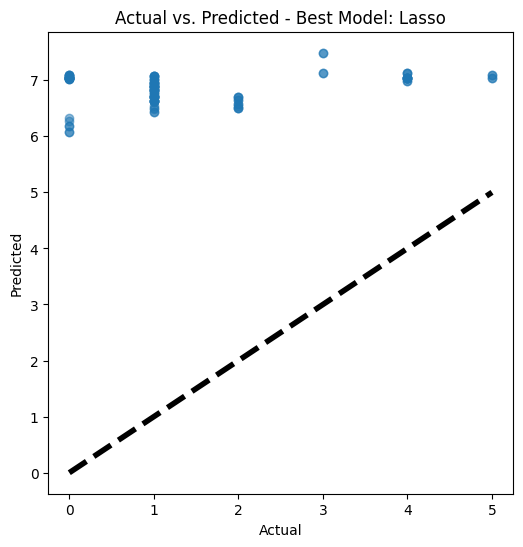

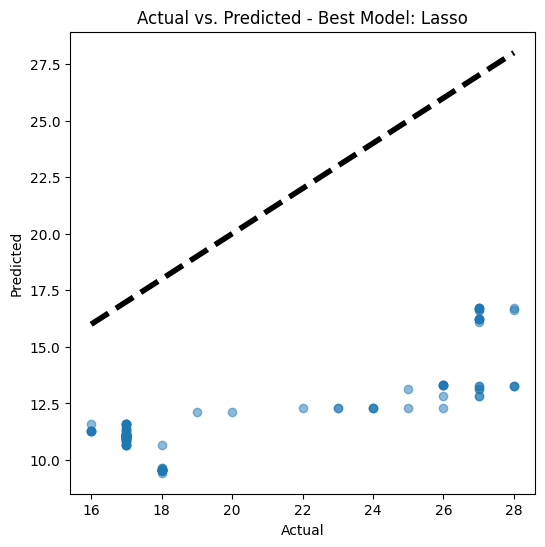

In [27]:
for i in set(df.number):
    df_i = df.loc[df['number'] == i]
    y = df_i['available_bikes']
    X = df_i.drop(['available_bikes'], axis=1)
    # print(X.shape)
    addHourDayMonth(X)
    # Handling categorical variables and missing values
    categorical_features = ["number",'weather_main', 'weather_description',"banking"]
    numerical_features = X.drop(columns=categorical_features).columns
    
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ])
    models = {
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Linear Regression': LinearRegression(),
        # "RandomForestRegressor": RandomForestRegressor()
    }
    
    model_pipelines = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        model_pipelines[name] = pipeline
        
    # Number of points to be used as test data
    test_size = 120
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]    
    model_scores = {}
    for name, pipeline in model_pipelines.items():
        # Using negative MSE to make it easier to compare (higher is better)
        scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
        model_scores[name] = scores.mean()
    
    best_model_name = max(model_scores, key=model_scores.get)
    best_pipeline = model_pipelines[best_model_name]
    
    # Fit and predict using the best model
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Linear Regression': LinearRegression(),
    # "RandomForestRegressor": RandomForestRegressor()
    }

    model_pipelines = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        model_pipelines[name] = pipeline
    
    model_scores = {}
    for name, pipeline in model_pipelines.items():
        # Using negative MSE to make it easier to compare (higher is better)
        scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
        model_scores[name] = scores.mean()
    
    best_model_name = max(model_scores, key=model_scores.get)
    best_pipeline = model_pipelines[best_model_name]
    
    # Fit and predict using the best model
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    
    # Visualization
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted - Best Model: {best_model_name}')
    plt.savefig(f'plots/{i}-{best_model_name}.png')
    joblib.dump(best_pipeline, f'models/{i}.joblib')

Inference:

In [39]:
from datetime import datetime
import requests
import json

OpenWeather_api_key = "6ac1c4119c9a1919193d6b37a98a9b0b"

In [49]:
dtForecast = int(datetime.strptime("2024-03-08T12:20:38Z", "%Y-%m-%dT%H:%M:%SZ").timestamp())

In [50]:
weatherResponse = requests.get(f"https://api.openweathermap.org/data/3.0/onecall/timemachine?lat={53}&lon={-6}&dt={dtForecast}&appid={OpenWeather_api_key}")

In [51]:
def parse_item(item):
    rain = item.get('rain', {'1h': None}).get('1h')
    snow = item.get('snow', {'1h': None}).get('1h')
    weather_main = item['weather'][0]['main'] if 'weather' in item and item['weather'] else None
    weather_description = item['weather'][0]['description'] if 'weather' in item and item['weather'] else None
    return {
        'dt': item.get('dt'),
        'sunrise': item.get('sunrise'),
        'sunset': item.get('sunset'),
        'temp': item.get('temp'),
        'feels_like': item.get('feels_like'),
        'pressure': item.get('pressure'),
        'humidity': item.get('humidity'),
        'uvi': item.get('uvi'),
        'clouds': item.get('clouds'),
        'visibility': item.get('visibility'),
        'wind_speed': item.get('wind_speed'),
        'wind_deg': item.get('wind_deg'),
        'wind_gust': item.get('wind_gust'),
        'weather_main': weather_main,
        'weather_description': weather_description,
        'rain': rain,
        'snow': snow
    }

weatherJson = json.loads(weatherResponse.text)
weather = parse_item(weatherJson['data'][0])

In [52]:
station = {"number":13, "last_update":pd.to_datetime(dtForecast,unit='s'),"banking":0}
X_infer = pd.DataFrame.from_dict([station|weather])

In [53]:
filtered_features = [feature for feature in featuresList if feature in X_infer.columns]
X_infer = X_infer[filtered_features]

In [54]:
addHourDayMonth(X_infer)

In [55]:
X_infer

number  banking    temp  feels_like  pressure  humidity   uvi  clouds  \
0      13        0  281.88      278.17      1007        69  1.51      83   

   visibility  wind_speed  wind_deg  wind_gust weather_main  rain  \
0       10000        8.02        99       9.51       Clouds  None   

  weather_description  hour  day  month  
0       broken clouds    12    8      3

In [56]:
bestModel = joblib.load('BestModel.joblib')

In [57]:
bestModel.predict(X_infer)

array([5.21400624])